## **Tema**: Treinamento de uma CNN utilizando o dataset CIFAR-10, com uma an√°lise comparativa entre diferentes bibliotecas.
___

## **Parte 1:** An√°lise explorat√≥ria e pr√©-processamento dos dados

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
print("===== Formato dos dados =====")
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

===== Formato dos dados =====
x_train: (50000, 32, 32, 3)
y_train: (50000, 1)
x_test: (10000, 32, 32, 3)
y_test: (10000, 1)


* Existem **50000** imagens no conjunto de treinamento e **10000** no conjunto de teste. </br>
* As imagens s√£o de **32x32** pixels. </br>
* O **3** faz refer√™ncia a matriz RGB para identificar a cor de cada pixel

Como no dataset n√£o existe explicitamente o nome dos atributos vamos definir-los para facilitar o pr√©-processamento





In [ ]:
classes = ['aviao', 'automovel', 'passaro', 'gato', 'veado',
               'cachorro', 'sapo', 'cavalo', 'barco', 'caminhao']
#aviao: 0, automovel: 1, ... caminhao: 10

Para visualizar as 25 primeiras imagens do dataset

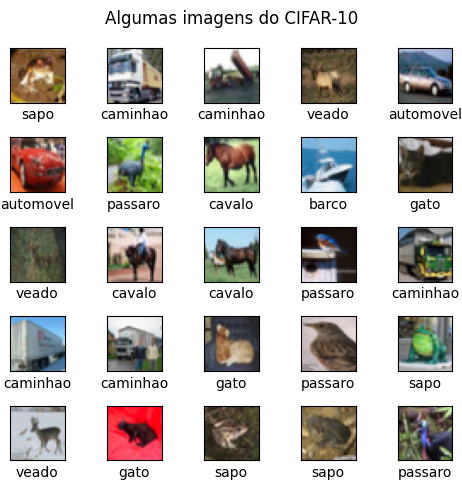

In [ ]:
plt.figure(figsize=(5, 5))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(classes[y_train[i][0]])
plt.suptitle('Algumas imagens do CIFAR-10', fontsize=12)
plt.tight_layout(rect=[0, 0.01, 1, 1])
plt.savefig('cifar10_sample_images.png')
plt.show()

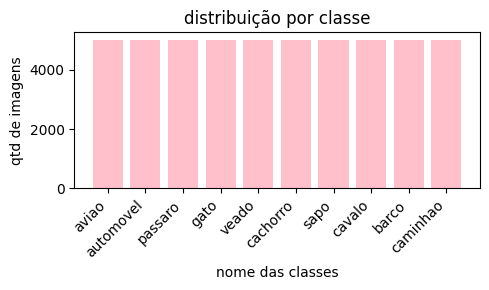

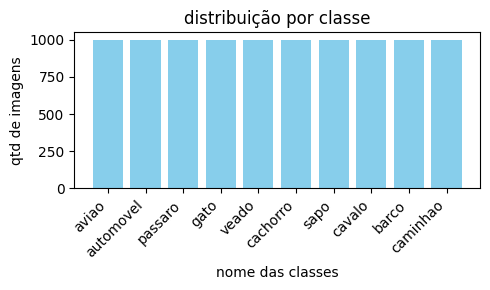

In [ ]:
# retorna a quantidade de classes
unique, counts = np.unique(y_train, return_counts=True)


plt.figure(figsize=(5, 3))
plt.bar(classes, counts, color='pink')
plt.xlabel('nome das classes')
plt.ylabel('qtd de imagens')
plt.title('distribui√ß√£o por classe')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

unique, counts = np.unique(y_test, return_counts=True)


plt.figure(figsize=(5, 3))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('nome das classes')
plt.ylabel('qtd de imagens')
plt.title('distribui√ß√£o por classe')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

√â poss√≠vel perceber que as classes est√£o igualmente distribuidas no *dataset*, cada uma tendo exatamente 5mil amostras no conjunto de treinamento e 10 mil no conjunto de teste

Para reduzir o tamanho do conjunto de dados, selecionamos apenas **tr√™s classes** que consideramos bem distintas, s√£o elas:
* avi√£o
* barco
* autom√≥vel <br/>

A partir dessa redu√ß√£o, esperamos **simplificar o problema de classifica√ß√£o**, para diminuir o tempo de treinamento necess√°rio e facilitar a an√°lise dos resultados, sem comprometer o entendimento dos conceitos fundamentais envolvidos.

In [ ]:
y_test

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

In [ ]:
#as classe ser√£o apenas aviao:0, automovel:1 e navio: 8
classes = [0, 1, 8]

#filtra o dataset para ter apenas as classes
mask_train = np.isin(y_train, classes).flatten()
x_train = x_train[mask_train]
y_train = y_train[mask_train]
mask_test = np.isin(y_test, classes).flatten()
x_test = x_test[mask_test]
y_test = y_test[mask_test]

# reindexar navio (√≠ndice 8 para 2)
y_train[y_train == 8] = 2
y_test[y_test == 8] = 2

In [ ]:
y_test

array([[2],
       [2],
       [0],
       ...,
       [0],
       [2],
       [1]], dtype=uint8)

In [ ]:
media_pixels = np.mean(x_train, axis=(0, 1, 2))
std_pixels = np.std(x_train, axis=(0, 1, 2))
print(f"m√©dia rgb dos pixels: {media_pixels}")
print(f"desvio padr√£o rgb dos pixels: {std_pixels}")

m√©dia rgb dos pixels: [126.40056491 130.92153919 135.21724349]
desvio padr√£o rgb dos pixels: [65.56178628 64.57908871 69.13642681]


In [ ]:
print(f"valor m√≠nimo em um pixel: {np.min(x_train)}")
print(f"valor maximo em um pixel: {np.max(x_train)}")

valor m√≠nimo em um pixel: 0
valor maximo em um pixel: 255


Os valores m√≠nimo e m√°ximo dos pixels indicam o intervalo dos dados, no caso do nosso dataset 0-255. <br/>
Atrav√©s dessa informa√ß√£o podemos realizar a **normaliza√ß√£o atrav√©s da divis√£o por 255** para escalar os valores entre 0 e 1, o que vai facilitar o aprendizado do modelo.

In [ ]:
x_train = x_train/255.0
x_test = x_test/255.0

* **One-Hot enconding:**
Ao inv√©s de representar a sa√≠da como um n√∫mero indicando a classe, o One-Hot Encoding vai transforma esse n√∫mero em um vetor bin√°rio. Nesse vetor, apenas a posi√ß√£o correspondente √† classe verdadeira √© marcada com 1, e todas as outras posi√ß√µes s√£o 0.

Por exemplo, se temos 3 classes, o r√≥tulo "classe 2" ser√° representado como:
[0, 0, 1]

Isso permite que o modelo entenda a classe como uma distribui√ß√£o categ√≥rica, facilitando o uso de fun√ß√µes de perda como a categorical_crossentropy.

In [ ]:
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

In [ ]:
y_test_cat

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

___
## **Parte 2:** Implementando a CNN

### **Usando Tensorflow/Keras**

###  Tuning de hiperpar√¢metros com TensorFlow/Keras


De modo a achar a **melhor configura√ß√£o dos hiperpar√¢metros** para a CNN nesse dataset, este c√≥digo realiza testes entre diferentes combina√ß√µes de taxa de aprendizado, taxa de dropout e tamanho da camada densa oculta. <br/>
Cada configura√ß√£o √© avaliada com base na acur√°cia de valida√ß√£o obtida ap√≥s o treinamento. Isso facilita a compreens√£o de como diferentes escolhas de hiperpar√¢metros afetam o desempenho do modelo.

* **Taxa de aprendizado:** define o qu√£o grandes s√£o os passos que o otimizador d√° ao ajustar os pesos da rede durante o treinamento. <br/>
Aprendemos que uma taxa muito alta pode fazer o modelo oscilar e n√£o convergir, enquanto uma taxa muito baixa pode deixar o treinamento lento ou travado em m√≠nimos locais. <br/>
Por isso, testamos os valores `0.001` e `0.0005`, que atrav√©s de pesquisas consideramos ser taxas frequentemente eficazes com o otimizador Adam.

* **Taxa de dropout:** representa a fra√ß√£o de neur√¥nios que s√£o desativados aleatoriamente durante o treinamento da rede. <br/>
Aprendemos que o dropout √© uma t√©cnica de regulariza√ß√£o importante para evitar overfitting, pois obriga a rede a aprender representa√ß√µes mais robustas, sem depender excessivamente de neur√¥nios espec√≠ficos. <br/>
Neste experimento, testamos os valores `0.3` (30%) e `0.5` (50%), que s√£o amplamente utilizados na literatura como taxas eficazes de regulariza√ß√£o para redes convolucionais.

* **Tamanho da camada densa oculta:** refere-se ao n√∫mero de neur√¥nios na camada totalmente conectada que precede a sa√≠da do modelo. <br/>
Aprendemos que camadas maiores tendem a aumentar a capacidade de representa√ß√£o da rede, mas tamb√©m elevam o risco de overfitting e o custo computacional. <br/>
Por isso, testamos os valores `64` e `128`, que representam configura√ß√µes equilibradas entre simplicidade e poder de modelagem, e s√£o comuns em tarefas de classifica√ß√£o de imagens.

Nessa etapa tamb√©m utilizaremos apenas 3 √©pocas apenas para o tuning dos hiperpar√¢metros de depois implementaremos o melhor modelo com 10 √©pocas para melhor acur√°cia.

## Arquitetura do Modelo

O modelo implementado possui a seguinte arquitetura:

- **Duas camadas convolucionais completas**, cada uma composta por:
  - Uma convolu√ß√£o 2D (`Conv2D`) com **32** e **64 filtros**, respectivamente, kernel 3√ó3, ativa√ß√£o ReLU e padding `'same'`;
  - Uma normaliza√ß√£o em lote (`BatchNormalization`) para estabilizar e acelerar o treinamento;
  - Uma opera√ß√£o de subamostragem (`MaxPooling2D`) com pool size 2√ó2 para redu√ß√£o da dimensionalidade .

- Ap√≥s as camadas convolucionais:
  - As ativa√ß√µes s√£o achatadas com `Flatten`;
  - Uma camada densa totalmente conectada (`Dense`) com **64 ou 128 neur√¥nios** ;
  - Uma camada de `Dropout` com taxa de **30% ou 50%** √© aplicada para reduzir overfitting;
  - A camada de sa√≠da √© uma `Dense` com **3 neur√¥nios** (correspondente ao n√∫mero de classes) e ativa√ß√£o `softmax`, respons√°vel por gerar as probabilidades de classifica√ß√£o.

O modelo foi treinado utilizando o otimizador **Adam**, fun√ß√£o de perda **categorical crossentropy**, e m√©trica de **acur√°cia**.


In [ ]:
learning_rates = [0.001, 0.0005]
dropouts = [0.3, 0.5]
hidden_sizes = [64, 128]
resultados_tf = []

for lr in learning_rates:
    for dp in dropouts:
        for hs in hidden_sizes:
            print(f"üîß TensorFlow - lr: {lr}, dropout: {dp}, hidden_size: {hs}")

            model = models.Sequential([
                layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3)),
                layers.BatchNormalization(),
                layers.MaxPooling2D((2,2)),

                layers.Conv2D(64, (3,3), activation='relu', padding='same'),
                layers.BatchNormalization(),
                layers.MaxPooling2D((2,2)),

                layers.Flatten(),
                layers.Dense(hs, activation='relu'),
                layers.Dropout(dp),
                layers.Dense(3, activation='softmax')
            ])

            model.compile(optimizer=Adam(learning_rate=lr),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

            history = model.fit(x_train, y_train_cat,
                                epochs=3,
                                batch_size=32,
                                validation_data=(x_test, y_test_cat),
                                verbose=0)

            acc = history.history['val_accuracy'][-1] * 100
            resultados_tf.append({'lr': lr, 'dropout': dp, 'hidden': hs, 'acc': acc})
            print(f"Acur√°cia final (valida√ß√£o): {acc:.2f}%")


üîß TensorFlow - lr: 0.001, dropout: 0.3, hidden_size: 64
Acur√°cia final (valida√ß√£o): 84.43%
üîß TensorFlow - lr: 0.001, dropout: 0.3, hidden_size: 128
Acur√°cia final (valida√ß√£o): 84.27%
üîß TensorFlow - lr: 0.001, dropout: 0.5, hidden_size: 64
Acur√°cia final (valida√ß√£o): 81.53%
üîß TensorFlow - lr: 0.001, dropout: 0.5, hidden_size: 128
Acur√°cia final (valida√ß√£o): 80.20%
üîß TensorFlow - lr: 0.0005, dropout: 0.3, hidden_size: 64
Acur√°cia final (valida√ß√£o): 85.80%
üîß TensorFlow - lr: 0.0005, dropout: 0.3, hidden_size: 128
Acur√°cia final (valida√ß√£o): 85.13%
üîß TensorFlow - lr: 0.0005, dropout: 0.5, hidden_size: 64
Acur√°cia final (valida√ß√£o): 85.37%
üîß TensorFlow - lr: 0.0005, dropout: 0.5, hidden_size: 128
Acur√°cia final (valida√ß√£o): 85.13%


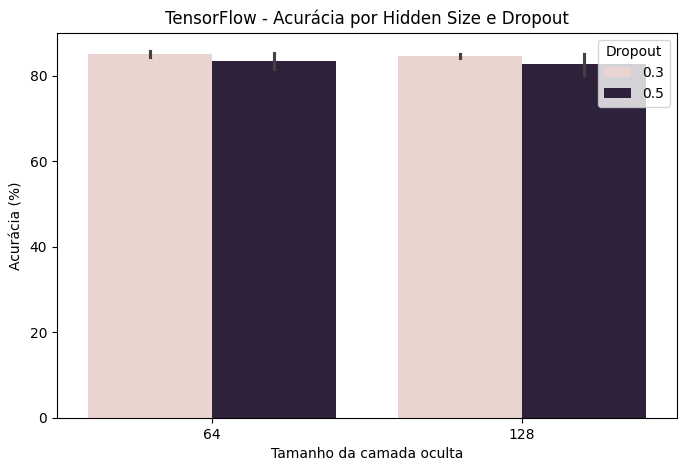

In [ ]:
df_tf = pd.DataFrame(resultados_tf)
plt.figure(figsize=(8,5))
sns.barplot(data=df_tf, x='hidden', y='acc', hue='dropout')
plt.title("TensorFlow - Acur√°cia por Hidden Size e Dropout")
plt.ylabel("Acur√°cia (%)")
plt.xlabel("Tamanho da camada oculta")
plt.legend(title="Dropout")
plt.show()


In [ ]:
model = models.Sequential([
                layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3)),
                layers.BatchNormalization(),
                layers.MaxPooling2D((2,2)),

                layers.Conv2D(64, (3,3), activation='relu', padding='same'),
                layers.BatchNormalization(),
                layers.MaxPooling2D((2,2)),

                layers.Flatten(),
                layers.Dense(64, activation='relu'),
                layers.Dropout(0.3),
                layers.Dense(3, activation='softmax')
            ])

model.compile(optimizer=Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.fit(x_train, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_data=(x_test, y_test_cat),
    verbose=0)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### **Avalia√ß√£o do modelo:**

94/94 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 15ms/step
üìã Relat√≥rio de Classifica√ß√£o:
              precision    recall  f1-score   support

       aviao       0.85      0.84      0.85      1000
   automovel       0.87      0.94      0.90      1000
       navio       0.87      0.82      0.84      1000

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000



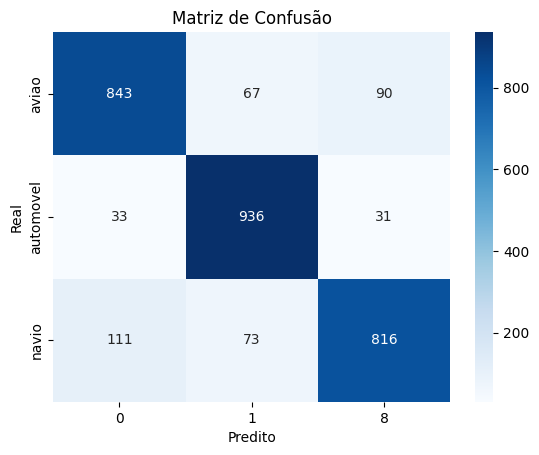

In [ ]:
classes_nomes = ["aviao", "automovel", "navio"]
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("üìã Relat√≥rio de Classifica√ß√£o:")
print(classification_report(y_test, y_pred_classes, target_names=classes_nomes))

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes_nomes, cmap='Blues')
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confus√£o")
plt.show()

### **Usando Pytorch**

Tuning de hiperpar√¢metros com Pytorch

In [ ]:
resultados_pt = []

x_train_transposed = np.transpose(x_train, (0, 3, 1, 2))
x_test_transposed = np.transpose(x_test, (0, 3, 1, 2))

x_train_tensor = torch.tensor(x_train_transposed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test_transposed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32)

class CNN_PyTorch_Tuned(nn.Module):
    def __init__(self, hidden_size, dropout_rate):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 8 * 8, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, 3)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for lr in learning_rates:
    for dp in dropouts:
        for hs in hidden_sizes:
            print(f"üîß PyTorch - lr: {lr}, dropout: {dp}, hidden: {hs}")

            model = CNN_PyTorch_Tuned(hs, dp).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

            model.train()
            for epoch in range(3):
                for inputs, labels in trainloader:
                  inputs, labels = inputs.to(device), labels.to(device)
                  labels = labels.view(-1)  # Remove dimens√£o extra, deixa shape (N,)
                  optimizer.zero_grad()
                  outputs = model(inputs)
                  loss = criterion(outputs, labels)
                  loss.backward()
                  optimizer.step()

            model.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    labels = labels.view(-1)  # Remove dimens√£o extra
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            acc = 100 * correct / total
            resultados_pt.append({'lr': lr, 'dropout': dp, 'hidden': hs, 'acc': acc})
            print(f"Acur√°cia: {acc:.2f}%")

üîß PyTorch - lr: 0.001, dropout: 0.3, hidden: 64
Acur√°cia: 87.83%
üîß PyTorch - lr: 0.001, dropout: 0.3, hidden: 128
Acur√°cia: 87.07%
üîß PyTorch - lr: 0.001, dropout: 0.5, hidden: 64
Acur√°cia: 83.20%
üîß PyTorch - lr: 0.001, dropout: 0.5, hidden: 128
Acur√°cia: 85.63%
üîß PyTorch - lr: 0.0005, dropout: 0.3, hidden: 64
Acur√°cia: 86.80%
üîß PyTorch - lr: 0.0005, dropout: 0.3, hidden: 128
Acur√°cia: 86.87%
üîß PyTorch - lr: 0.0005, dropout: 0.5, hidden: 64
Acur√°cia: 85.57%
üîß PyTorch - lr: 0.0005, dropout: 0.5, hidden: 128
Acur√°cia: 85.47%


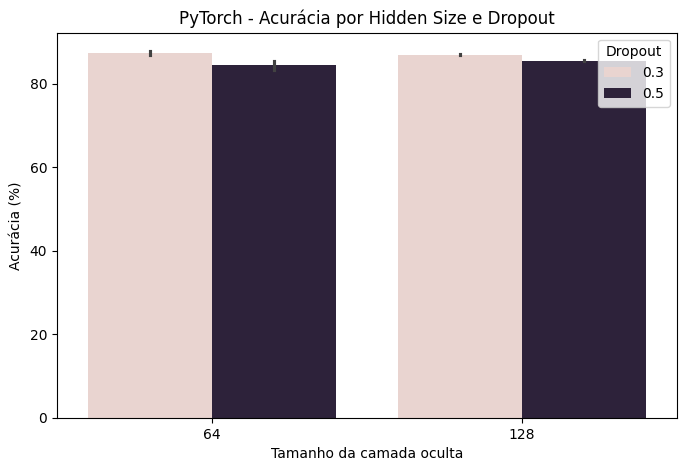

In [ ]:
#Visualiza√ß√£o dos resultados
df_pt = pd.DataFrame(resultados_pt)
plt.figure(figsize=(8,5))
sns.barplot(data=df_pt, x='hidden', y='acc', hue='dropout')
plt.title("PyTorch - Acur√°cia por Hidden Size e Dropout")
plt.ylabel("Acur√°cia (%)")
plt.xlabel("Tamanho da camada oculta")
plt.legend(title="Dropout")
plt.show()



___
## **Parte 3:** Avaliando os modelos

#1. Tabela comparativa dos resultados de tuning

In [ ]:
# Juntando ambos os DataFrames
df_tf["Framework"] = "TensorFlow"
df_pt["Framework"] = "PyTorch"
df_comparativo = pd.concat([df_tf, df_pt])

# Exibindo as melhores configura√ß√µes
df_comparativo.sort_values(by="acc", ascending=False).head(5)


lr  dropout  hidden        acc   Framework
0  0.0010      0.3      64  87.833333     PyTorch
1  0.0010      0.3     128  87.066667     PyTorch
5  0.0005      0.3     128  86.866667     PyTorch
4  0.0005      0.3      64  86.800000     PyTorch
4  0.0005      0.3      64  85.799998  TensorFlow

#2. Gr√°fico combinado por framework

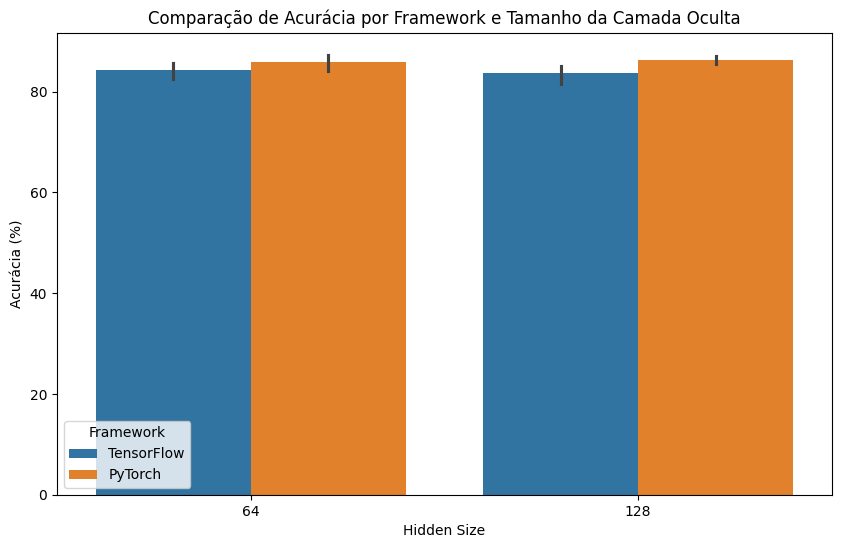

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=df_comparativo, x='hidden', y='acc', hue='Framework')
plt.title("Compara√ß√£o de Acur√°cia por Framework e Tamanho da Camada Oculta")
plt.ylabel("Acur√°cia (%)")
plt.xlabel("Hidden Size")
plt.legend(title="Framework")
plt.show()


___
## **Parte 4:** An√°lise comparativa

#1. Desempenho dos modelos
Neste projeto utilizamos duas das principais bibliotecas de Deep Learning ‚Äî TensorFlow/Keras e PyTorch ‚Äî para treinar redes convolucionais (CNNs) aplicadas √† classifica√ß√£o de imagens do dataset CIFAR-10. Ap√≥s treinar ambos os modelos e realizar tuning de hiperpar√¢metros, foi poss√≠vel observar pontos importantes que diferenciam as duas abordagens.

√â poss√≠vel perceber que o modelo com pytorch teve uma acur√°cia ligeiramente maior, mas n√£o podemos tomar conclus√µes a partir disso. No aspecto t√©cnico, TensorFlow/Keras oferece uma estrutura de codifica√ß√£o mais concisa e automatizada. A fun√ß√£o model.fit() encapsula o processo de treinamento, facilitando experimenta√ß√µes r√°pidas. J√° o PyTorch exige maior controle manual por meio de la√ßos expl√≠citos de treino e valida√ß√£o (for epoch), mas em contrapartida, permite maior flexibilidade na arquitetura e na manipula√ß√£o do fluxo de dados.

Por fim, podemos concluir que n√£o h√° um framework superior absoluto, mas sim contextos em que um pode ser mais vantajoso que o outro. TensorFlow/Keras √© recomendado para quem busca rapidez e simplicidade na constru√ß√£o de modelos, enquanto PyTorch √© ideal para quem precisa de maior controle e customiza√ß√£o. O sucesso do modelo depende mais do cuidado com pr√©-processamento, ajuste de hiperpar√¢metros e an√°lise dos resultados do que da escolha da ferramenta em si.

